In [4]:
#!/usr/bin/env python3
"""
Trains a convolutional neural network to classify the CIFAR 10 dataset.
"""

import tensorflow as tf
import tensorflow.keras as K  # type: ignore


def preprocess_data(X, Y):
    X_p = K.applications.inception_v3.preprocess_input(X)
    Y_p = K.utils.to_categorical(Y, num_classes=10)
    return X_p, Y_p


def train_model():
    # Load the CIFAR-10 dataset
    (X_train, y_train), (X_test, y_test) = K.datasets.cifar10.load_data()

    # Preprocess the data
    X_train, y_train = preprocess_data(X_train, y_train)
    X_test, y_test = preprocess_data(X_test, y_test)

    # Define the base model
    input_tensor = K.layers.Input(shape=(32, 32, 3))
    x = K.layers.Lambda(
        lambda image: tf.image.resize(image, (224, 224)),
    )(input_tensor)
    base_model = K.applications.InceptionV3(
        weights="imagenet", include_top=False, input_tensor=x
    )

    # Freeze the base model layers
    for layer in base_model.layers[:300]:
        layer.trainable = False

    # Add the top layers for classification
    x = K.layers.GlobalAveragePooling2D()(base_model.output)
    x = K.layers.Dense(1024, activation="relu")(x)
    predictions = K.layers.Dense(10, activation="softmax")(x)
    model = K.models.Model(inputs=base_model.input, outputs=predictions)

    checkpoint = K.callbacks.ModelCheckpoint(
        "cifar10.h5", monitor="val_accuracy", save_best_only=True
    )

    # Compile the model
    model.compile(
        optimizer=K.optimizers.Adam(learning_rate=2e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint],
    )

    # Save the model
    model.summary()
    model.save("cifar10.h5")

    return history

if __name__ == "__main__":
    history = train_model()

Epoch 1/10
1563/1563 [==============================] - 136s 84ms/step - loss: 0.5532 - accuracy: 0.8257 - val_loss: 0.4014 - val_accuracy: 0.8634
Epoch 2/10
1563/1563 [==============================] - 129s 82ms/step - loss: 0.3448 - accuracy: 0.8821 - val_loss: 0.3564 - val_accuracy: 0.8797
Epoch 3/10
1563/1563 [==============================] - 129s 82ms/step - loss: 0.2939 - accuracy: 0.9004 - val_loss: 0.3229 - val_accuracy: 0.8905
Epoch 4/10
1563/1563 [==============================] - 128s 82ms/step - loss: 0.2551 - accuracy: 0.9121 - val_loss: 0.3324 - val_accuracy: 0.8872
Epoch 5/10
1563/1563 [==============================] - 129s 82ms/step - loss: 0.2237 - accuracy: 0.9244 - val_loss: 0.3013 - val_accuracy: 0.8968
Epoch 6/10
1563/1563 [==============================] - 129s 82ms/step - loss: 0.1972 - accuracy: 0.9340 - val_loss: 0.3035 - val_accuracy: 0.8994
Epoch 7/10
1563/1563 [==============================] - 129s 82ms/step - loss: 0.1736 - accuracy: 0.9423 - val_loss: 0

In [5]:
# to fix issue with saving keras applications
K.learning_phase = K.backend.learning_phase

_, (X, Y) = K.datasets.cifar10.load_data()
X_p, Y_p = preprocess_data(X, Y)
model = K.models.load_model("cifar10.h5")
model.evaluate(X_p, Y_p, batch_size=128, verbose=1)

79/79 [==============================] - 22s 227ms/step - loss: 0.2980 - accuracy: 0.9029


[0.2980397939682007, 0.902899980545044]

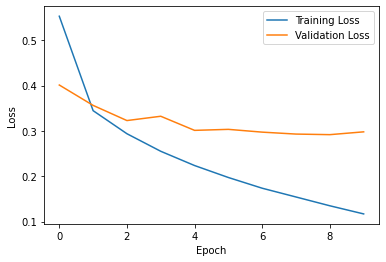

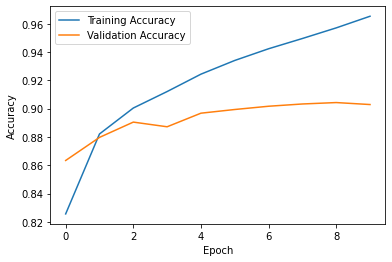

In [6]:
import matplotlib.pyplot as plt


# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()